## Definition of the seq2seq neuronal architecture

<img src="https://www.tensorflow.org/images/basic_seq2seq.png" />

Comparatively to what we see in the image, our neural network deals with signal rather than letters. Also, we don't have the feedback mechanism yet. 

-------------------------------------------

A,B,C is encoder input
go is a decoder input (zero input)

decoder input is last one decoder output

<img src="images/E3_1.png" />

<img src="images/E3_2.png" />

<img src="images/E3_3.png" />

<img src="images/E3_4.png" />

In [1]:
exercise = 2  # Possible values: 1, 2, 3, or 4.

from datasets import generate_x_y_data_v1, generate_x_y_data_v2, generate_x_y_data_v3, generate_x_y_data_v4 

# We choose which data function to use below, in function of the exericse. 
if exercise == 1:
    generate_x_y_data = generate_x_y_data_v1
if exercise == 2:
    generate_x_y_data = generate_x_y_data_v2
if exercise == 3:
    generate_x_y_data = generate_x_y_data_v3
if exercise == 4:  
    generate_x_y_data = generate_x_y_data_v4
import tensorflow as tf  # Version 1.0 or 0.12
import numpy as np
import matplotlib.pyplot as plt

# This is for the notebook to generate inline matplotlib 
# charts rather than to open a new window every time: 
%matplotlib inline


C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sample_x,sample_y = generate_x_y_data(isTrain=True, batch_size=3)

In [3]:
sample_x.shape

(15, 3, 1)

In [4]:

# Backward compatibility for TensorFlow's version 0.12: 
try:
    tf.nn.seq2seq = tf.contrib.legacy_seq2seq
    tf.nn.rnn_cell = tf.contrib.rnn
    tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell
    print("TensorFlow's version : 1.0 (or more)")
except: 
    print("TensorFlow's version : 0.12")

TensorFlow's version : 1.0 (or more)


In [4]:
seq_length = sample_x.shape[0]  # Time series will have the same past and future (to be predicted) lenght. 
batch_size = 50  # Low value used for live demo purposes - 100 and 1000 would be possible too, crank that up!

output_dim = sample_y.shape[-1]
input_dim = sample_x.shape[-1]  # Output dimension (e.g.: multiple signals at once, tied in time)
hidden_dim = 35  # Count of hidden neurons in the recurrent units. 
layers_stacked_count = 2  # Number of stacked recurrent cells, on the neural depth axis. 

# Optmizer: 
learning_rate = 0.007  # Small lr helps not to diverge during training. 
nb_iters = 2500  # How many times we perform a training step (therefore how many times we show a batch). 
lr_decay = 0.92  # default: 0.9 . Simulated annealing.
momentum = 0.5  # default: 0.0 . Momentum technique in weights update
lambda_l2_reg = 0.003  # L2 regularization of weights - avoids overfitting


In [5]:
tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()
with tf.variable_scope('Seq2seq'):
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
           for t in range(seq_length)
    ]
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
          for t in range(seq_length)
    ]
    dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO") ] + enc_inp[:-1]
    cells = []
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            # cells.append(tf.nn.rnn_cell.BasicLSTMCell(...))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    dec_outputs, dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp, 
        dec_inp, 
        cell
    )
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]

In [6]:
with tf.variable_scope('Loss'):
    # L2 loss
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        
    # L2 regularization (to avoid overfitting and to have a  better generalization capacity)
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
            
    loss = output_loss + lambda_l2_reg * reg_loss

with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=lr_decay, momentum=momentum)
    train_op = optimizer.minimize(loss)

In [7]:
def train_batch(batch_size):
    """
    Training step that optimizes the weights 
    provided some batch_size X and Y examples from the dataset. 
    """
    X, Y = generate_x_y_data(isTrain=True, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    _, loss_t = sess.run([train_op, loss], feed_dict)
    return loss_t

def test_batch(batch_size):
    """
    Test step, does NOT optimizes. Weights are frozen by not
    doing sess.run on the train_op. 
    """
    X, Y = generate_x_y_data(isTrain=False, batch_size=batch_size)
    feed_dict = {enc_inp[t]: X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]: Y[t] for t in range(len(expected_sparse_output))})
    loss_t = sess.run([loss], feed_dict)
    return loss_t[0]


# Training
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range(nb_iters+1):
    train_loss = train_batch(batch_size)
    train_losses.append(train_loss)
    
    if t % 10 == 0: 
        # Tester
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step {}/{}, train loss: {}, \tTEST loss: {}".format(t, nb_iters, train_loss, test_loss))

print("Fin. train loss: {}, \tTEST loss: {}".format(train_loss, test_loss))


Step 0/2500, train loss: 565.9466552734375, 	TEST loss: 274.2423400878906
Step 10/2500, train loss: 159.88421630859375, 	TEST loss: 216.09991455078125
Step 20/2500, train loss: 131.0115966796875, 	TEST loss: 224.61109924316406
Step 30/2500, train loss: 205.04736328125, 	TEST loss: 159.27169799804688
Step 40/2500, train loss: 185.37986755371094, 	TEST loss: 162.58993530273438
Step 50/2500, train loss: 179.22433471679688, 	TEST loss: 188.21324157714844
Step 60/2500, train loss: 194.26437377929688, 	TEST loss: 157.1842803955078
Step 70/2500, train loss: 174.36134338378906, 	TEST loss: 170.5437774658203
Step 80/2500, train loss: 181.8460235595703, 	TEST loss: 174.07431030273438
Step 90/2500, train loss: 171.87815856933594, 	TEST loss: 182.115966796875
Step 100/2500, train loss: 176.6538543701172, 	TEST loss: 187.45718383789062
Step 110/2500, train loss: 152.03456115722656, 	TEST loss: 167.889892578125
Step 120/2500, train loss: 188.07415771484375, 	TEST loss: 187.2935791015625
Step 130/250

Step 1080/2500, train loss: 79.40486907958984, 	TEST loss: 63.112606048583984
Step 1090/2500, train loss: 64.45450592041016, 	TEST loss: 64.6440200805664
Step 1100/2500, train loss: 63.249351501464844, 	TEST loss: 93.89247131347656
Step 1110/2500, train loss: 61.109344482421875, 	TEST loss: 75.15008544921875
Step 1120/2500, train loss: 96.7742691040039, 	TEST loss: 77.10274505615234
Step 1130/2500, train loss: 72.80298614501953, 	TEST loss: 63.3283576965332
Step 1140/2500, train loss: 81.30894470214844, 	TEST loss: 86.54190063476562
Step 1150/2500, train loss: 64.65524291992188, 	TEST loss: 69.84302520751953
Step 1160/2500, train loss: 74.97432708740234, 	TEST loss: 54.842254638671875
Step 1170/2500, train loss: 59.33293151855469, 	TEST loss: 78.75753021240234
Step 1180/2500, train loss: 47.801063537597656, 	TEST loss: 55.05965805053711
Step 1190/2500, train loss: 58.75712966918945, 	TEST loss: 44.24823760986328
Step 1200/2500, train loss: 75.04694366455078, 	TEST loss: 74.582176208496

Step 2150/2500, train loss: 48.590904235839844, 	TEST loss: 50.445289611816406
Step 2160/2500, train loss: 36.82356262207031, 	TEST loss: 53.4283332824707
Step 2170/2500, train loss: 54.31223678588867, 	TEST loss: 45.87450408935547
Step 2180/2500, train loss: 47.26040267944336, 	TEST loss: 74.2513198852539
Step 2190/2500, train loss: 64.0684585571289, 	TEST loss: 43.168556213378906
Step 2200/2500, train loss: 46.115745544433594, 	TEST loss: 49.70564270019531
Step 2210/2500, train loss: 57.59007263183594, 	TEST loss: 48.65272903442383
Step 2220/2500, train loss: 42.47507858276367, 	TEST loss: 43.273345947265625
Step 2230/2500, train loss: 53.90354919433594, 	TEST loss: 45.184017181396484
Step 2240/2500, train loss: 62.861961364746094, 	TEST loss: 45.3987922668457
Step 2250/2500, train loss: 48.0550537109375, 	TEST loss: 44.826541900634766
Step 2260/2500, train loss: 49.87971878051758, 	TEST loss: 63.483795166015625
Step 2270/2500, train loss: 51.45991134643555, 	TEST loss: 61.1714172363

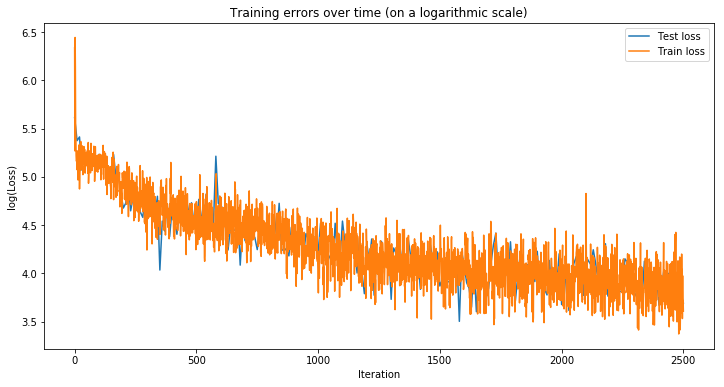

In [8]:

# Plot loss over time:
plt.figure(figsize=(12, 6))
plt.plot(
    np.array(range(0, len(test_losses)))/float(len(test_losses)-1)*(len(train_losses)-1), 
    np.log(test_losses), 
    label="Test loss"
)
plt.plot(
    np.log(train_losses), 
    label="Train loss"
)
plt.title("Training errors over time (on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc='best')
plt.show()


Let's visualize 3 predictions with our signals:
1


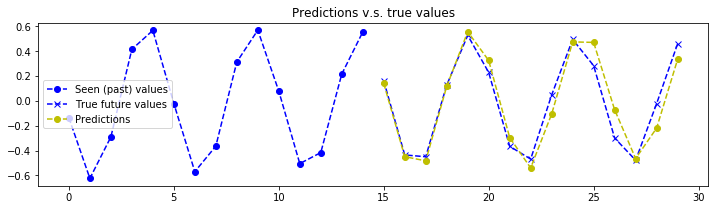

1


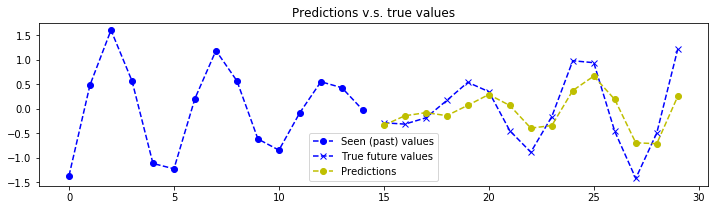

1


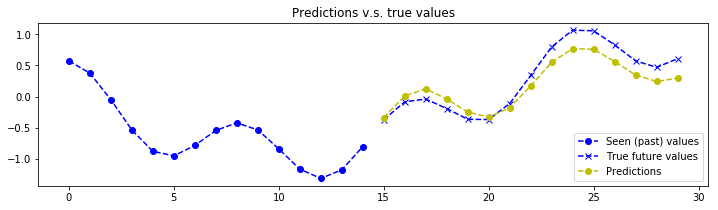

Reminder: the signal can contain many dimensions at once.
In that case, signals have the same color.
In reality, we could imagine multiple stock market symbols evolving,
tied in time together and seen at once by the neural network.


In [15]:
# Test
nb_predictions = 3
print("Let's visualize {} predictions with our signals:".format(nb_predictions))

X, Y = generate_x_y_data(isTrain=False, batch_size=nb_predictions)
feed_dict = {enc_inp[t]: X[t] for t in range(seq_length)}
outputs = np.array(sess.run([reshaped_outputs], feed_dict)[0])

for j in range(nb_predictions): 
    plt.figure(figsize=(12, 3))
    
    for k in range(output_dim):
        past = X[:,j,k]
        expected = Y[:,j,k]
        pred = outputs[:,j,k]
        
        label1 = "Seen (past) values" if k==0 else "_nolegend_"
        label2 = "True future values" if k==0 else "_nolegend_"
        label3 = "Predictions" if k==0 else "_nolegend_"
        plt.plot(range(len(past)), past, "o--b", label=label1)
        plt.plot(range(len(past), len(expected)+len(past)), expected, "x--b", label=label2)
        plt.plot(range(len(past), len(pred)+len(past)), pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()

print("Reminder: the signal can contain many dimensions at once.")
print("In that case, signals have the same color.")
print("In reality, we could imagine multiple stock market symbols evolving,")
print("tied in time together and seen at once by the neural network.")

以上是訓練的結果，由於input的data都是 sin cos 等函數組合的，並不是一個很難預測的data 感覺他還可以更fit一點，但是我沒有讓他跑更多的iteration不然應該可以更好一些，seq2seq是目前time series 的預測做得最好的model，很多比賽都在使用，只是會在對模型上增加一點例如說attation阿或是說一些其他的輔助，結構上並沒有太多差異，主因是因為相比傳統RNN他其實是把所有的input都看完encode這些資訊之後才開始做預測得，可以解決普通的RNN其實他會有所謂的先看到前面的information可是還沒看到後面的問題